### 階層モデル
`StanとRでベイズ統計モデリング`より, 第８章をPythonで.

#### 何をするのか
説明変数だけでは説明がつかないが、現実世界では割と自明として扱われる*グループ差*を扱うためのモデルを学ぶ.

> グループ差を表すパラメータは類似しており, 特定の分布から生成される

グループでまとめてあげれば, はっきりした分布の形が見える的なことを言っているのか？
典型的には, 特定の分布を平均0・標準偏差$\sigma$の正規分布として, $\sigma$には無情報事前分布を設定してデータから推定をする.

### 8.1 階層モデルの導入
+ 大手会社4社(これがグループ) : KIDで表現
  + 年齢X: 実際の年齢から23を引いている(初任給を表現)
  + 年収Y

In [57]:
salary2 = pd.read_csv("./datasets/data-salary-2.csv")
salary2.X = salary2.X.astype(int)
salary2.Y = salary2.Y.astype(int)

#### 8.1.2 グループ差を考えない場合
会社による年収の平均とか上がり具合とかを考慮せずに, 単純に一つの回帰式$a+bX$で分析してみる.
+ $Y[n] = y_{base}[n] + \epsilon[n]$
+ $y_{base}[n] = a + bX[n]$
+ $\epsilon[n] ~ Norm(0, \sigma_{Y})$
    + 誤差はデータセット固有のものとして扱う

In [32]:
# 回帰式はstatsmodelsで簡単に求まる
X = salary2.X.values
y = salary2.Y.values
X = sm.add_constant(X)
mod1 = sm.OLS(y, X, has_const=True).fit()
mod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.627
Method:                 Least Squares   F-statistic:                     66.42
Date:                Sun, 20 Aug 2017   Prob (F-statistic):           7.25e-10
Time:                        02:21:44   Log-Likelihood:                -223.47
No. Observations:                  40   AIC:                             450.9
Df Residuals:                      38   BIC:                             454.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        375.9064     23.567     15.951      0.000     328.198     423.615
x1            11.0639      1.358      8.150      0.000       8.316      13.812
==============================================================================
Omnibus:                        2.911   Durbin-Watson:                   0.887
Prob(Omnibus):                  0.233   Jarque-Bera (JB):                2.627
Skew:                           0.612   Prob(JB):                        0.269
Kurtosis:                       2.718   Cond. No.                         39.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

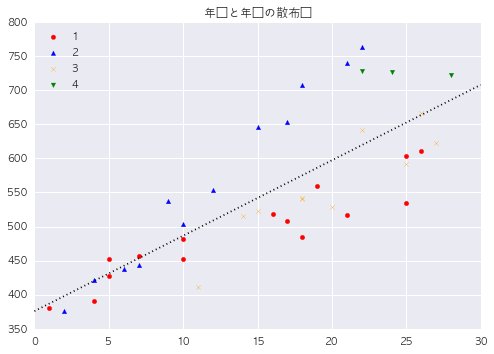

In [62]:
markers = ["o", "^", "x", "v"]
colors = ["r", "b", "orange", "g"]
plt.figure(1)
for i, grouped in enumerate(salary2.groupby("KID")):
    plt.scatter(x=grouped[1].X.values, y=grouped[1].Y.values, marker=markers[i], color=colors[i], label=grouped[0])
plt.xlim(0, 30)
plt.title("年齢と年収の散布図")
plt.legend(loc="upper left")
# statsmodelsで得られた回帰式をプロット
x_ =  np.arange(0, 30, 0.01)
y_ = 375.9064 + x_ * 11.0639
plt.plot(x_, y_, color="k", linestyle=":")
plt.show()

一見良さそうに見えるが, グループごとに見ていくとどうだろう.
`KID=2`である会社では, 年収の上昇率が他の会社よりも大きい感じがする.
`KID=4`である会社については, もはや年齢をとるほど年収が低くなっているではないか.

これはグループによる差を考慮するべきだ.

#### 8.1.3 グループごとに切片と傾きを持つ場合
プロットから, 「新卒の基本年収」と「年齢に伴う昇給額」は異なることがわかった.
会社ごとに切片と傾きを推定してみる.
ただし, 同一の会社内での年収のばらつき(例えば同じ会社で同じ年齢でも年収が違うといったような)は, 全ての会社で$\sigma_{Y}$として共通であるとする.

単純に, 会社ごとにグループ分けして, それぞれで回帰分析を実行する場合に等しい.
今回は`PyStan`を利用してみる.

In [55]:
model_code1 = """
data {
  int N;
  int K;
  int X[N];
  int Y[N];
  int<lower=1, upper=K> KID[N];
}

parameters {
  real a[K];
  real b[K];
  real<lower=0> s_Y;
}

model {
  for (n in 1:N)
    Y[n] ~ normal(a[KID[n]] + b[KID[n]]*X[n], s_Y);
}
"""

In [58]:
anualIncome = salary2.Y.values
age = salary2.X.values
kid = salary2.KID
dat = { "X": age, "Y": anualIncome, "KID": kid, "N": len(salary2), "K": len(salary2.KID.unique()) }
sm1 = pystan.StanModel(model_code=model_code1)
fit1 = sm1.sampling(data=dat, iter=1000, chains=4)

Inference for Stan model: anon_model_1b9c11a0f08ab8cda56470b413ff494b.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a[0] 387.38    0.37   13.6 360.01 378.44 387.44 396.18  414.6   1388    1.0
a[1] 328.85    0.42  16.32 296.23 318.18 328.39  340.0 361.64   1533    1.0
a[2] 314.24    0.94  33.79 250.86 290.14 314.36 336.83 379.32   1289    1.0
a[3] 748.71    4.63 160.67 432.16  639.3 742.79  854.8 1071.1   1204    1.0
b[0]   7.51    0.02   0.84   5.82   6.97   7.52   8.07    9.2   1352    1.0
b[1]  19.84    0.03    1.2   17.5  19.02  19.84  20.64  22.23   1489    1.0
b[2]  12.43    0.05   1.68   9.21  11.27  12.43  13.57  15.64   1287    1.0
b[3]  -0.94    0.19    6.5 -14.13  -5.23  -0.64   3.35  11.85   1207    1.0
s_Y   27.09     0.1   3.49  21.16   24.6   26.7  29.37  34.89   1201    1.0
lp__ -147.9     0.1   2.32 -153.1 -149.3 -147.6 -146.

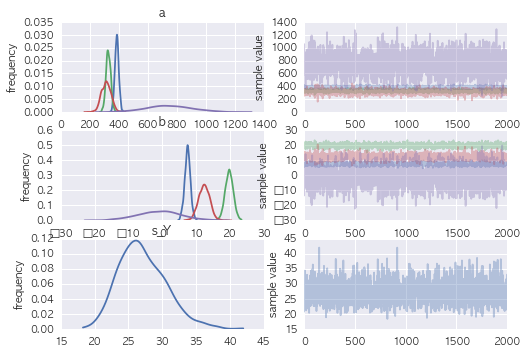

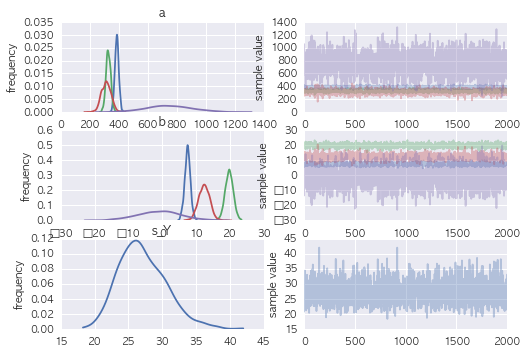

In [59]:
print(fit1)
fit1.plot()

ベイズ信頼区間めっちゃ面白い...
というか, PyStanで`fit.plot()`するだけでたまらなく楽しい...
それぞれのKIDごとのパラメータを推定できている. やはり, 会社によって初任給も昇給額も異なることがわかる.

+ 初任給の高さなら, KID=0の会社
+ 昇給額の大きさなら, KID=1の会社
+ KID=3の会社の初任給は群を抜いているように見えるが, 単に回帰係数が負の値をとっているだけのよう
こんな感じの考察を行うこともできるように...

### 8.1.4 階層モデル
各会社の$a[k]$を...
1. 全ての会社で共通の全体平均
2. 会社差を表す項
  + 平均$0$, 標準偏差$\sigma_{a}$の正規分布から生成されると仮定
  
の二つに分けて考える.

$b[k]$についても同様に...
1. 全ての会社で共通する年収の上がり具合の平均
2. 会社に応じてばらつく部分
  + 平均$0$, 標準偏差$\sigma_{b}$の正規分布から生成されると仮定
  
の二つに分けて考える.

このようにパラメータを`全体で共通する`ものと`グループ間でのばらつき`に分けて考えることが特徴的.  
$\sigma_{a}$, $\sigma_{b}$の事前分布(データが得られる前の仮定)には, 無情報事前分布を設定し, その後データからそれぞれを推定する.

> 階層的に事前分布を設定しているので階層モデルと呼ばれる.

#### モデル式
+ $Y[n] ~ Normal(a[KID[n]] + b[KID[n]]X[n], \sigma_{Y})$
+ $a[k] = a_{全体平均} + a_{会社差}[k]$
+ $a_{会社差}[k] ~ Normal(0, \sigma_{a})$
+ $b[k] = b_{全体平均} + b_{会社差}[k]$
+ $b_{会社差}[k] ~ Normal(0, \sigma_{b})$

これらのモデルを利用し, データから$\sigma_{Y}$, $a_{全体平均}$, $b_{全体平均}$, $a_{会社差}$, $b_{会社差}$, $\sigma_{a}$, $\sigma_{b}$を推定する.

In [71]:
model_code2 = """
data {
  int N;
  int K;
  int X[N];
  int Y[N];
  int<lower=1, upper=K> KID[N];
}
parameters {
  real a0;
  real a[K];
  real b0;
  real b[K];
  real<lower=0> s_Y;
  real<lower=0> s_a;
  real<lower=0> s_b;
}
model {
  for (k in 1:K) {
    a[k] ~ normal(a0, s_a);
    b[k] ~ normal(b0, s_b);
  }

  for (n in 1:N)
    Y[n] ~ normal(a[KID[n]] + b[KID[n]]*X[n], s_Y);
}
"""
sm2 = pystan.StanModel(model_code=model_code2)
fit2 = sm2.sampling(data=dat, iter=1000, chains=4)

Inference for Stan model: anon_model_9daf8b75f2c57e9ef0f577d2b9290fc3.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a0    408.4   28.12  285.4 153.22 338.07  370.4 424.65 767.17    103   1.04
a[0] 383.42    0.43  14.56 354.18 374.01 383.67  393.1 411.26   1150    1.0
a[1] 334.48    0.53  17.44 299.31 322.37 334.82  346.4 368.85   1067    1.0
a[2] 323.39    1.24  33.88 251.09 302.37 325.67 346.07  384.1    751    1.0
a[3] 495.39    6.66 140.12 309.05 380.74 464.89 580.23 823.27    443    1.0
b0    12.04    0.34   7.44  -2.96   9.04  12.27  15.07  26.85    485    1.0
b[0]   7.72    0.03   0.91   5.99    7.1   7.74   8.31   9.52    945    1.0
b[1]  19.42    0.04   1.28  16.89  18.53   19.4  20.37  21.79   1120    1.0
b[2]  12.02    0.06   1.65   8.99   10.9  11.93  13.02  15.68    782    1.0
b[3]   9.25    0.27   5.65  -3.94   5.75  10.43   13.

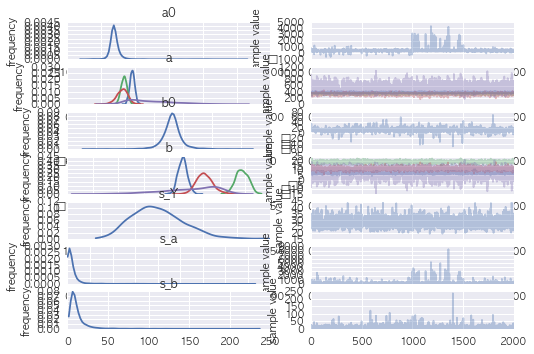

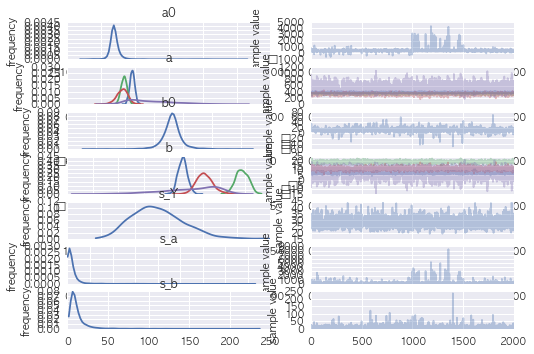

In [73]:
print(fit2)
fit2.plot()

推定の結果をまとめると, $a_{全体平均}$の中央値は370.4, $b_{全体平均}$の中央値は12.27ということになる.
また, グループ差を考慮した二つのmodelの各パラメータの推定値をみると, 階層モデルの方がそうでないモデルよりも, データ全体での推定値に近い値をとっていることがわかる. この, 階層モデルで起こる現象を`Shrinkage`と呼ぶ.

### 8.2 複数の階層を持つ階層モデル
会社という単位のグループ差だけではなく, 業界単位のグループ差も考慮したモデルを作成したい.

In [74]:
salary3 = pd.read_csv("./datasets/data-salary-3.csv")
salary3.dtypes

X      int64
Y      int64
KID    int64
GID    int64
dtype: object

In [77]:
# 業界差を考慮しない場合の回帰直線を求める
X2 = salary3.X.values
X2 = sm.add_constant(X2)
y2 = salary3.Y.values
res2 = sm.OLS(y2, X2, has_const=True).fit()

In [81]:
res2.params # 回帰分析の結果

array([ 340.15765644,   23.17921946])

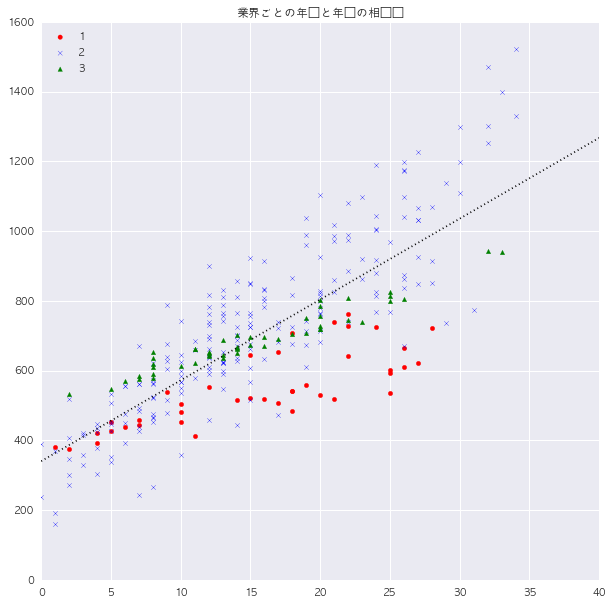

In [84]:
# まず, 業界ごとに年齢と年収のプロットを行う
markers = ["o", "x", "^"]
colors = ["r", "b", "g"]
plt.figure(100, figsize=(10, 10))
for i, grouped in enumerate(salary3.groupby("GID")):
    plt.scatter(grouped[1].X.values, grouped[1].Y.values, marker=markers[i], color=colors[i], label=grouped[0])
    
# 回帰直線をプロット
x__ = np.arange(0, 40, 0.01)
y__ = res2.params[0] + res2.params[1] * x__
plt.plot(x__, y__, color="k", linestyle=":")

plt.legend(loc="upper left")
plt.title("業界ごとの年齢と年収の相関図")
plt.xlim(0,40)

plt.show()

In [113]:
model_code3 = """

data {
  int N;
  int G;
  int K;
  int X[N];
  int Y[N];
  int<lower=1, upper=K> KID[N];
  int<lower=1, upper=G> K2G[K];
}

parameters {
  real a0;
  real a[K];
  real a1[G];
  real b0;
  real b[K];
  real b1[G];
  real<lower=0> s_Y;
  real<lower=0> s_a;
  real<lower=0> s_b;
  real<lower=0> s_ag;
  real<lower=0> s_bg;
}



model {
  for (g in 1:G) {
    a1[g] ~ normal(a0, s_ag);
    b1[g] ~ normal(b0, s_bg);
  }

  for (k in 1:K) {
    a[k] ~ normal(a1[K2G[k]], s_a);
    b[k] ~ normal(b1[K2G[k]], s_b);
  }

  for (n in 1:N)
    Y[n] ~ normal(a[KID[n]] + b[KID[n]]*X[n], s_Y);
}
"""
K2G = salary3[["KID", "GID"]].drop_duplicates().GID.values
dat2 = {"N":len(salary3), "G":len(salary3.GID.unique()),"K":len(salary3.KID.unique()),"X":salary3.X, "Y":salary3.Y, "KID":salary3.KID, "K2G":K2G}

In [114]:
sm3 = pystan.StanModel(model_code=model_code3)
fit3 = sm3.sampling(data=dat2, iter=1000, chains=4)

Inference for Stan model: anon_model_0d19b5df5acf1ad054d289c0cee150f3.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a0     408.6   33.77 449.25 -234.9 304.44 383.03 464.03 1318.2    177   1.02
a[0]  363.75    1.21  27.25 307.02 346.95 365.01 381.61 416.84    505    1.0
a[1]  356.75    1.06  28.83 298.47 337.66 356.76 375.16 414.47    733    1.0
a[2]  350.98     1.4  37.12 273.15 328.22 353.49 375.23 421.92    701    1.0
a[3]  362.09    1.59  40.79 278.84 338.12 362.73 387.61 441.64    659    1.0
a[4]  295.02    0.69  23.98 240.39 281.58 296.02 310.51 339.43   1216    1.0
a[5]  329.19     2.1  34.83 276.23 303.88 323.33 348.81 413.61    276    1.0
a[6]  310.24    0.91   21.0  273.0 295.27 308.61 322.98 356.58    532    1.0
a[7]  303.51    1.26  28.74 247.79 286.21 302.13 319.75 363.99    518    1.0
a[8]  285.99     1.5  28.09 217.27 271.21 2

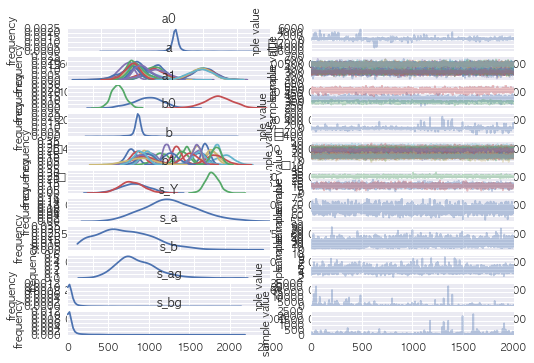

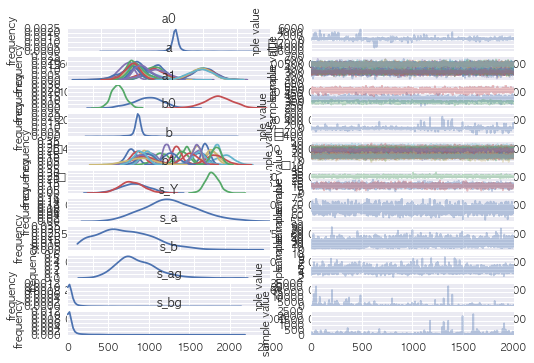

In [116]:
print(fit3)
fit3.plot()